In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
from copy import deepcopy as dc
import random
import geometry_bspline as bsp_geom
import NeuralImplicit as NI

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class Siren(nn.Module):
    def __init__(self, architecture, outermost_linear=False,
                 first_omega_0=60, hidden_omega_0=60):
        super().__init__()
        self.architecture = architecture
        in_features = architecture[0]
        out_features = architecture[-1]
        hidden_layers = len(architecture)-2

        self.loss_history = []
        self.optimizer = None
        self.name = "SIREN"
        self.lr_scheduler = None

        self.net = []
        self.net.append(SineLayer(in_features, architecture[1],
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers-1):
            self.net.append(SineLayer(architecture[i+1],architecture[i+2] ,
                                      is_first=False, omega_0=hidden_omega_0))
        self.net.append(SineLayer(architecture[-2],architecture[-2] ,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(architecture[-2], out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / architecture[-2]) / hidden_omega_0,
                                              np.sqrt(6 / architecture[-2]) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(architecture[-2], out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)


    def forward(self, coords):
        #coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output
class SIRELU(nn.Module):
    def __init__(self, architecture, outermost_linear=False,
                first_omega_0=60, hidden_omega_0=60):
        super().__init__()
        self.architecture = architecture
        in_features = architecture[0]
        out_features = architecture[-1]
        hidden_layers = len(architecture)-2

        self.loss_history = []
        self.optimizer = None
        self.name = "SIRELU"
        self.lr_scheduler = None

        self.net = []
        self.net.append(SineLayer(in_features, architecture[1],
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers-1):
            if i % 2 ==0:
                self.net.append(nn.Linear(architecture[i+1],architecture[i+2]))
                self.net.append(nn.ReLU())
            else:
                self.net.append(SineLayer(architecture[i+1],architecture[i+2] ,
                                      is_first=False, omega_0=hidden_omega_0))
        if hidden_layers % 2 == 1:
            self.net.append(nn.Linear(architecture[-2],architecture[-2]))
            self.net.append(nn.ReLU())
        else:
            self.net.append(SineLayer(architecture[-2],architecture[-2] ,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(architecture[-2], out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / architecture[-2]) / hidden_omega_0,
                                              np.sqrt(6 / architecture[-2]) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(architecture[-2], out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)


    def forward(self, coords):
        #coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output

In [2]:
architecture = [2,256,256,1]
model = NI.Siren(architecture, outermost_linear=True, first_omega_0=60, hidden_omega_0=60)
print(f"number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
model.optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())
model.lr_scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=100, gamma=0.7)

model2 = NI.SIRELU(architecture=architecture,outermost_linear=True,first_omega_0=60,hidden_omega_0=60)
print(f"number of parameters: {sum(p.numel() for p in model2.parameters() if p.requires_grad)}")
model2.optimizer = torch.optim.Adam(lr=1e-4, params=model2.parameters())
model2.lr_scheduler = torch.optim.lr_scheduler.StepLR(model2.optimizer, step_size=100, gamma=0.7)
#print(model2.net)

model3 = NI.PE_Relu(architecture=architecture,num_freqs=70,include_input=True)
print(f"number of parameters: {sum(p.numel() for p in model3.parameters() if p.requires_grad)}")
model3.optimizer = torch.optim.Adam(lr=1e-4, params=model3.parameters())
model3.lr_scheduler = torch.optim.lr_scheduler.StepLR(model3.optimizer, step_size=100, gamma=0.7)
print(model3.net)


number of parameters: 132609
number of parameters: 132609
number of parameters: 138497
Sequential(
  (0): Linear(in_features=282, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
def train_model(model,num_epochs=10):
    report_interval = num_epochs // 10
    criterion = nn.MSELoss()
    star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
    knots = bsp_geom.create_knot_vector(len(star_cp), degree=1)
    L_EIKON = 1e3
    L_BND = 1e4
    L_BND_GRAD = 1e1
    L_XI = 3e2
    NUM_POINTS = 1000
    for epoch in range(num_epochs):
        star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
        boundary_pts, t_values = bsp_geom.generate_points_on_curve(star_cp, num_points=NUM_POINTS, degree=1, device=None, return_t=True)
        other_pts = torch.randn((NUM_POINTS,2))*2-1
        other_pts = other_pts.clone().detach().requires_grad_(True)
        pred_other = model(other_pts)
        grds = torch.autograd.grad(outputs=pred_other, inputs=other_pts, grad_outputs=torch.ones_like(pred_other),retain_graph=True, allow_unused=True, create_graph=True)
        eikonloss = torch.sum(grds[0]**2,dim=1)
        eikonloss_output = torch.abs(1-torch.sqrt(eikonloss)).mean()
        boundary_pts = boundary_pts.clone().detach().requires_grad_(True)
        bond_normal = bsp_geom.bspline_normalvectors(t_values,star_cp,knots,degree=1)
        # elementwise scalar product of bond_normal and gradient of pred_boundary
        pred_boundary = model(boundary_pts)
        grds_boundary = torch.autograd.grad(outputs=pred_boundary, inputs=boundary_pts, grad_outputs=torch.ones_like(pred_boundary),retain_graph=True, allow_unused=True, create_graph=True)
        #print(grds_boundary)
        scalar_prods = torch.sum(grds_boundary[0] * bond_normal, dim=1)
        scalar_loss = torch.abs(1- scalar_prods).mean()
        loss_boundary = torch.abs(torch.mean(torch.abs(pred_boundary)))
        loss_xi = torch.mean(torch.exp(-100*torch.abs(pred_other)))
        loss = L_BND*loss_boundary + L_EIKON*eikonloss_output + L_XI*loss_xi + L_BND_GRAD*scalar_loss
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        model.lr_scheduler.step()
        model.loss_history.append(loss.item())
        if epoch % report_interval == 0:
            CALCULATE_ERROR = True
            if CALCULATE_ERROR:
                pts = torch.randn((5000,2))*2-1
                with torch.no_grad():
                    pred = model(pts)
                    star_sdf = bsp_geom.bspline_signed_distance_vectorized(pts,star_cp,degree=1)
                    error = criterion(pred.squeeze(), star_sdf)
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}, SDF Error: {error.item():.6f}")
                print(f"Losses: Boundary: {L_BND*loss_boundary.item():.6f}, Eikonal: {L_EIKON*eikonloss_output.item():.6f}, Xi: {L_XI*loss_xi.item():.6f}, Scalar prod: {L_BND_GRAD*scalar_loss.item():.6f}")
            else:
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            
train_model(model,100)

Epoch 0, Loss: 269.339630, SDF Error: 5.900920
Losses: Boundary: 20.358004, Eikonal: 243.941262, Xi: 3.970275, Scalar prod: 1.070064
Epoch 10, Loss: 279.969940, SDF Error: 6.193625
Losses: Boundary: 18.839623, Eikonal: 255.327106, Xi: 4.638199, Scalar prod: 1.165020
Epoch 20, Loss: 307.841187, SDF Error: 6.031923
Losses: Boundary: 21.505766, Eikonal: 280.244708, Xi: 4.590190, Scalar prod: 1.500533
Epoch 30, Loss: 307.663849, SDF Error: 6.045000
Losses: Boundary: 19.714201, Eikonal: 280.767947, Xi: 5.596944, Scalar prod: 1.584750
Epoch 40, Loss: 308.729675, SDF Error: 5.863794
Losses: Boundary: 20.831130, Eikonal: 281.688094, Xi: 4.607394, Scalar prod: 1.603097
Epoch 50, Loss: 314.881897, SDF Error: 6.016235
Losses: Boundary: 18.253608, Eikonal: 290.876478, Xi: 4.235143, Scalar prod: 1.516679
Epoch 60, Loss: 307.900146, SDF Error: 5.966599
Losses: Boundary: 20.017170, Eikonal: 280.575067, Xi: 5.740492, Scalar prod: 1.567402
Epoch 70, Loss: 323.649414, SDF Error: 5.814953
Losses: Boundar

In [3]:
def train_model_old(model,num_epochs=10):
    report_interval = num_epochs // 10
    criterion = nn.MSELoss()
    star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
    knots = bsp_geom.create_knot_vector(len(star_cp), degree=1)
    for epoch in range(num_epochs):
        pts = torch.randn((15000,2))*2-1
        #pts = pts.clone().detach().requires_grad_(True)
        pred = model(pts)
        target = bsp_geom.bspline_signed_distance_vectorized(pts,star_cp,degree=1)
        loss_sdf = criterion(pred.squeeze(), target)
        loss = loss_sdf
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        model.lr_scheduler.step()
        model.loss_history.append(loss.item())
        if epoch % report_interval == 0:
            CALCULATE_ERROR = False
            if CALCULATE_ERROR:
                pts = torch.randn((5000,2))*2-1
                with torch.no_grad():
                    pred = model(pts)
                    star_sdf = bsp_geom.bspline_signed_distance_vectorized(pts,star_cp,degree=1)
                    error = criterion(pred.squeeze(), star_sdf)
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}, SDF Error: {error.item():.6f}")
            else:
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
train_model_old(model3,100)

Epoch 0, Loss: 5.556047
Epoch 10, Loss: 4.872040
Epoch 20, Loss: 4.142325
Epoch 30, Loss: 3.434866


KeyboardInterrupt: 

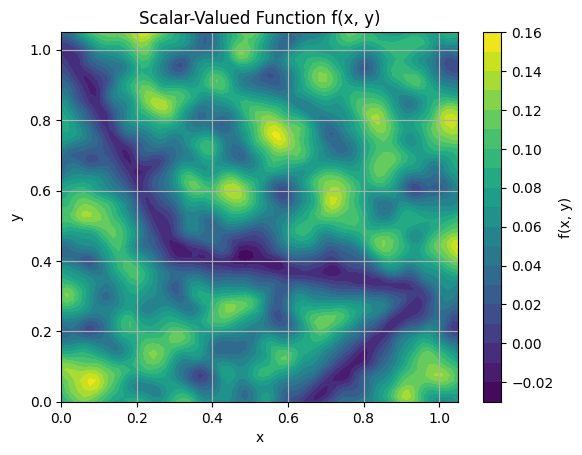

In [35]:
import NeuralImplicit
NeuralImplicit.plotDisctancefunction(model,70,False)